Extracting cloud features: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  5.00it/s]



Classification Report:
              precision    recall  f1-score   support

   Non-Cloud       0.95      0.97      0.96      1500
       Cloud       0.34      0.21      0.26       100

    accuracy                           0.93      1600
   macro avg       0.65      0.59      0.61      1600
weighted avg       0.91      0.93      0.92      1600

Average Precision Score: 0.21


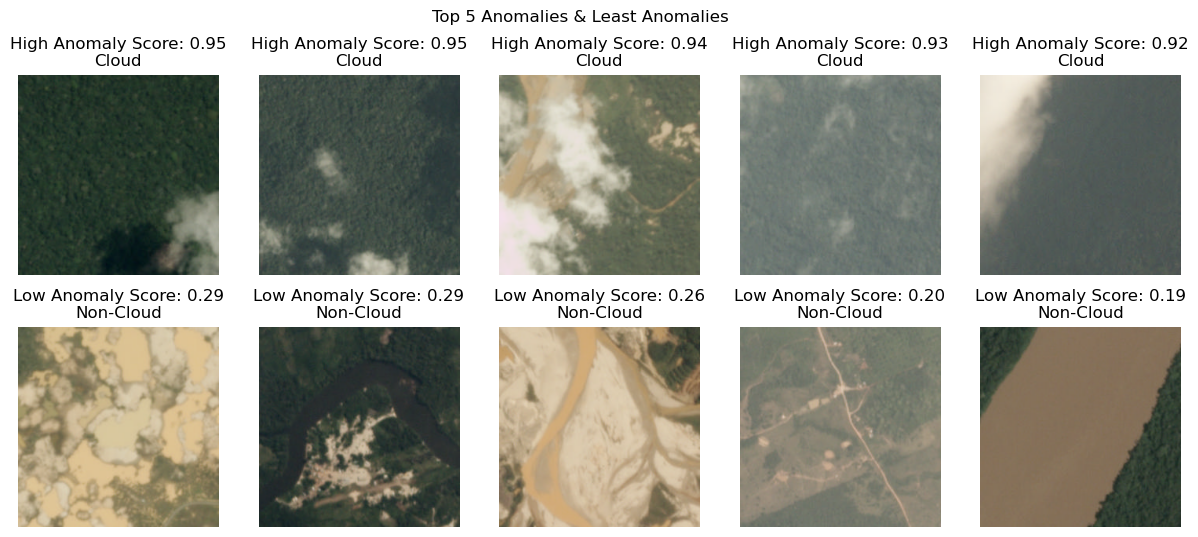

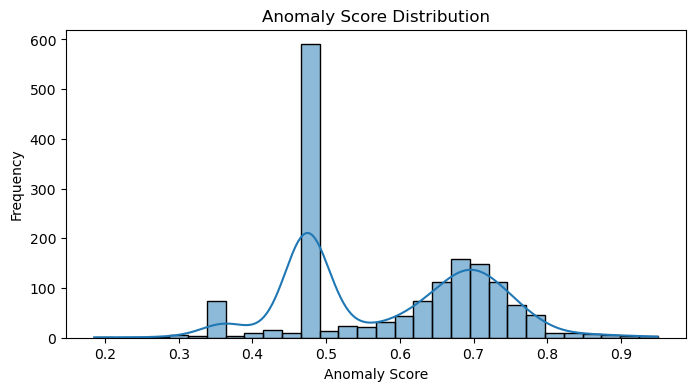

AttributeError: module 'networkx' has no attribute 'to_numpy_matrix'

<Figure size 800x800 with 0 Axes>

In [9]:
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import community
from sklearn.metrics import (precision_recall_curve, average_precision_score, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Feature Extractors
class FeatureExtractor:
    def __init__(self):
        self.model = None
        self.preprocess = None
        
    def extract(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_t = self.preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        with torch.no_grad():
            features = self.model(batch_t)
        return features.squeeze().cpu().numpy()


class ResNet50Extractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1]).to(device)  # Remove FC layer
        self.model.eval()
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])


# Step 1: Feature Extraction
def load_and_extract_features(data_dir, extractor):
    features, labels, img_paths = [], [], []
    
    for label, class_dir in enumerate(['noncloud', 'cloud']):
        dir_path = os.path.join(data_dir, class_dir)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        
        img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not img_files:
            raise ValueError(f"No images found in {dir_path}")
        
        for img_name in tqdm(img_files, desc=f"Extracting {class_dir} features"):
            img_path = os.path.join(dir_path, img_name)
            try:
                feat = extractor.extract(img_path)
                features.append(feat.flatten())
                labels.append(label)
                img_paths.append(img_path)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    
    return np.array(features), np.array(labels), img_paths


# Step 2: Graph Construction
def build_knn_graph(features, k=10, similarity_threshold=0.6):
    features_norm = StandardScaler().fit_transform(features)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(features_norm)
    distances, indices = nbrs.kneighbors(features_norm)
    
    G = nx.Graph()
    for i in range(len(features_norm)):
        G.add_node(i)
    
    for i in range(len(features_norm)):
        for j_idx, j in enumerate(indices[i][1:]):
            sim = 1 - distances[i][j_idx+1]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)
    
    return G


# Step 3: Anomaly Scoring
def compute_graph_anomaly_scores(G):
    scores = {}
    
    # PageRank
    pr = nx.pagerank(G)
    pr_scores = np.array(list(pr.values()))
    scores['pagerank'] = {node: 1 - (score / max(pr_scores)) for node, score in pr.items()}
    
    # Eccentricity
    try:
        ecc = nx.eccentricity(G)
    except:
        ecc = {node: max(nx.single_source_shortest_path_length(G, node).values()) for node in G.nodes()}
    scores['eccentricity'] = {node: score/max(ecc.values()) for node, score in ecc.items()}
    
    # Combined score
    combined_scores = {node: 0.5 * scores['pagerank'][node] + 0.5 * scores['eccentricity'][node] for node in G.nodes()}
    
    return combined_scores


# Step 4: Evaluation
def evaluate_anomaly_detection(labels, anomaly_scores):
    y_true = labels
    y_scores = np.array([anomaly_scores[i] for i in range(len(labels))])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    return classification_report(y_true, y_pred, target_names=['Non-Cloud', 'Cloud']), ap


# Step 5: Visualization
def visualize_results(img_paths, anomaly_scores, labels, top_n=5):
    sorted_indices = np.argsort(-np.array(list(anomaly_scores.values())))  
    top_indices = sorted_indices[:top_n]  
    bottom_indices = sorted_indices[-top_n:]  

    plt.figure(figsize=(15, 6))

    # Highest anomaly scores
    for i, idx in enumerate(top_indices):
        plt.subplot(2, top_n, i+1)
        img = Image.open(img_paths[idx])
        plt.imshow(img)
        plt.title(f"High Anomaly Score: {anomaly_scores[idx]:.2f}\n{'Cloud' if labels[idx] else 'Non-Cloud'}")
        plt.axis('off')

    # Lowest anomaly scores (least anomalous)
    for i, idx in enumerate(bottom_indices):
        plt.subplot(2, top_n, top_n + i + 1)
        img = Image.open(img_paths[idx])
        plt.imshow(img)
        plt.title(f"Low Anomaly Score: {anomaly_scores[idx]:.2f}\n{'Cloud' if labels[idx] else 'Non-Cloud'}")
        plt.axis('off')

    plt.suptitle(f'Top {top_n} Anomalies & Least Anomalies')
    plt.show()

    # Anomaly score histogram
    plt.figure(figsize=(8, 4))
    sns.histplot(list(anomaly_scores.values()), bins=30, kde=True)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Anomaly Score")
    plt.ylabel("Frequency")
    plt.show()

    # Heatmap of KNN similarity
    plt.figure(figsize=(8, 8))
    adjacency_matrix = nx.to_numpy_matrix(build_knn_graph(features), weight='weight')
    sns.heatmap(adjacency_matrix, cmap="coolwarm", square=True)
    plt.title("Graph Connectivity Heatmap")
    plt.show()


# Main Execution
if __name__ == "__main__":
    data_dir = r"E:\\Ml project\\archive"
    extractor = ResNet50Extractor()
    
    features, labels, img_paths = load_and_extract_features(data_dir, extractor)
    G = build_knn_graph(features)
    anomaly_scores = compute_graph_anomaly_scores(G)
    report, ap = evaluate_anomaly_detection(labels, anomaly_scores)
    
    print("\nClassification Report:")
    print(report)
    print(f"Average Precision Score: {ap:.2f}")
    
    visualize_results(img_paths, anomaly_scores, labels)


Extracting cloud features: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:20<00:00,  4.99it/s]



Classification Report:
              precision    recall  f1-score   support

   Non-Cloud       0.95      0.97      0.96      1500
       Cloud       0.34      0.21      0.26       100

    accuracy                           0.93      1600
   macro avg       0.65      0.59      0.61      1600
weighted avg       0.91      0.93      0.92      1600

Average Precision Score: 0.21


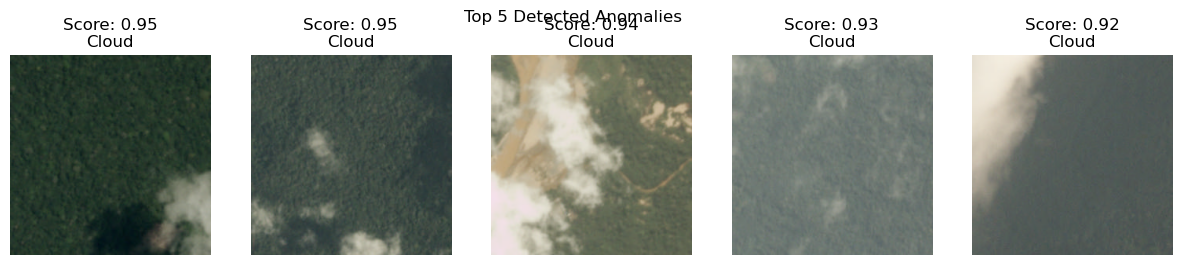

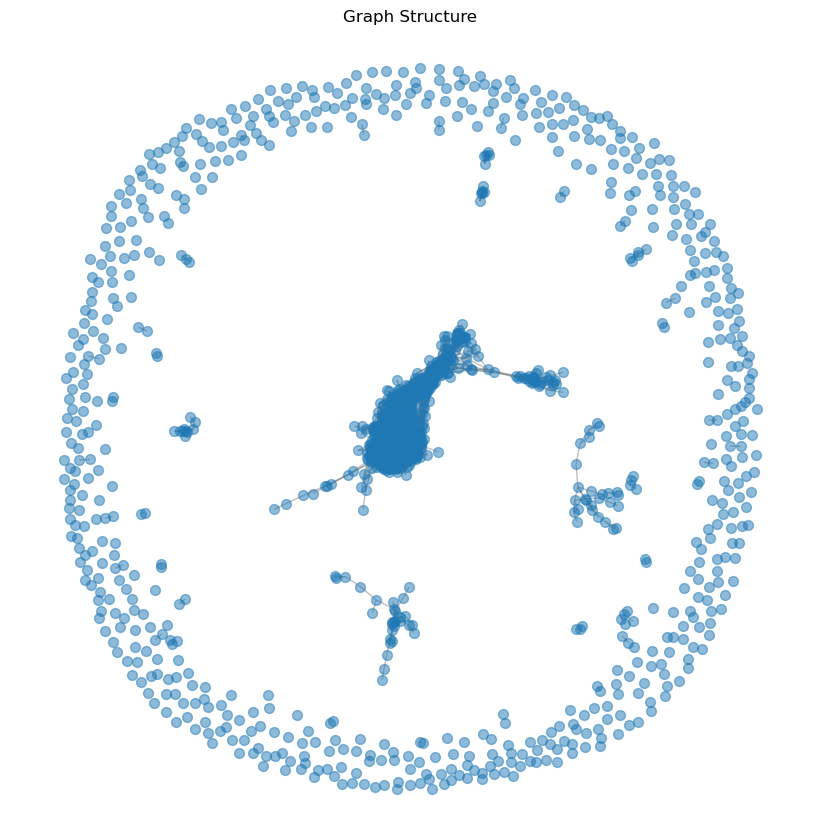

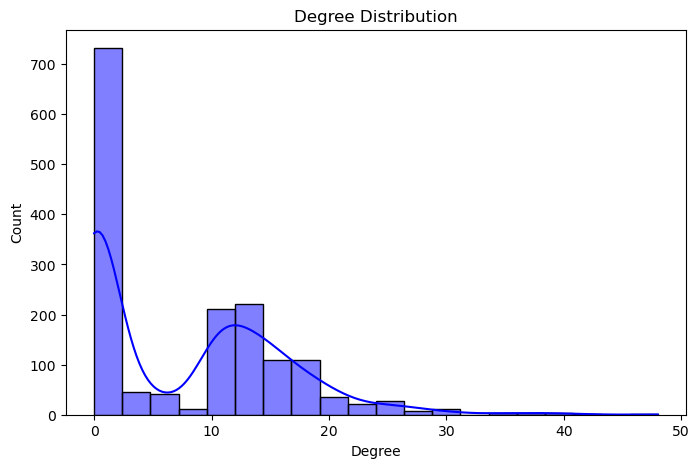

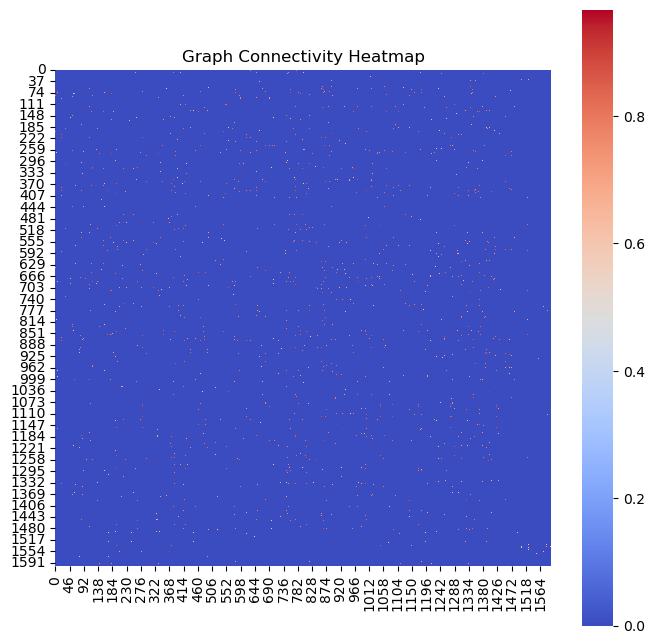

In [14]:
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.preprocessing import StandardScaler
from networkx.algorithms import community
from sklearn.metrics import (classification_report, precision_recall_curve, 
                             average_precision_score, f1_score, precision_score, recall_score)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor Class
class FeatureExtractor:
    def __init__(self):
        self.model = None
        self.preprocess = None
        
    def extract(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_t = self.preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        with torch.no_grad():
            features = self.model(batch_t)
        return features.squeeze().cpu().numpy()

class ResNet50Extractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1]).to(device)  # Remove FC layer
        self.model.eval()
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Step 1: Feature Extraction
def load_and_extract_features(data_dir, extractor):
    features, labels, img_paths = [], [], []
    
    for label, class_dir in enumerate(['noncloud', 'cloud']):
        dir_path = os.path.join(data_dir, class_dir)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        
        img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not img_files:
            raise ValueError(f"No images found in {dir_path}")
        
        for img_name in tqdm(img_files, desc=f"Extracting {class_dir} features"):
            img_path = os.path.join(dir_path, img_name)
            try:
                feat = extractor.extract(img_path)
                features.append(feat.flatten())
                labels.append(label)
                img_paths.append(img_path)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    
    return np.array(features), np.array(labels), img_paths

# Step 2: Graph Construction
def build_knn_graph(features, k=10, similarity_threshold=0.6):
    features_norm = StandardScaler().fit_transform(features)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(features_norm)
    distances, indices = nbrs.kneighbors(features_norm)
    
    G = nx.Graph()
    for i in range(len(features_norm)):
        G.add_node(i)
    
    for i in range(len(features_norm)):
        for j_idx, j in enumerate(indices[i][1:]):
            sim = 1 - distances[i][j_idx+1]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)
    
    return G

# Step 3: Anomaly Scoring
def compute_graph_anomaly_scores(G):
    scores = {}
    
    # PageRank
    pr = nx.pagerank(G)
    pr_scores = np.array(list(pr.values()))
    scores['pagerank'] = {node: 1 - (score / max(pr_scores)) for node, score in pr.items()}
    
    # Eccentricity
    try:
        ecc = nx.eccentricity(G)
    except:
        ecc = {node: max(nx.single_source_shortest_path_length(G, node).values()) for node in G.nodes()}
    scores['eccentricity'] = {node: score/max(ecc.values()) for node, score in ecc.items()}
    
    # Combined score
    combined_scores = {node: 0.5 * scores['pagerank'][node] + 0.5 * scores['eccentricity'][node] for node in G.nodes()}
    
    return combined_scores

# Step 4: Evaluation
def evaluate_anomaly_detection(labels, anomaly_scores):
    y_true = labels
    y_scores = np.array([anomaly_scores[i] for i in range(len(labels))])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    return classification_report(y_true, y_pred, target_names=['Non-Cloud', 'Cloud']), ap

# Step 5: Visualization
def visualize_results(img_paths, anomaly_scores, labels, top_n=5):
    top_indices = np.argsort(-np.array(list(anomaly_scores.values())))[:top_n]
    
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_n, i+1)
        img = Image.open(img_paths[idx])
        plt.imshow(img)
        plt.title(f"Score: {anomaly_scores[idx]:.2f}\n{'Cloud' if labels[idx] else 'Non-Cloud'}")
        plt.axis('off')
    plt.suptitle(f'Top {top_n} Detected Anomalies')
    plt.show()
    
    # Graph Structure
    plt.figure(figsize=(8, 8))
    G = build_knn_graph(features)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, node_size=50, edge_color="gray", alpha=0.5)
    plt.title("Graph Structure")
    plt.show()

    # Degree Distribution
    plt.figure(figsize=(8, 5))
    degrees = [val for (node, val) in G.degree()]
    sns.histplot(degrees, bins=20, kde=True, color="blue")
    plt.xlabel("Degree")
    plt.ylabel("Count")
    plt.title("Degree Distribution")
    plt.show()
    
    # Heatmap of KNN similarity
    plt.figure(figsize=(8, 8))
    adjacency_matrix = nx.to_numpy_array(build_knn_graph(features), weight='weight')
    sns.heatmap(adjacency_matrix, cmap="coolwarm", square=True)
    plt.title("Graph Connectivity Heatmap")
    plt.show()

# Main Execution
if __name__ == "__main__":
    data_dir = r"E:\\Ml project\\archive"
    extractor = ResNet50Extractor()
    
    features, labels, img_paths = load_and_extract_features(data_dir, extractor)
    G = build_knn_graph(features)
    anomaly_scores = compute_graph_anomaly_scores(G)
    report, ap = evaluate_anomaly_detection(labels, anomaly_scores)
    
    print("\nClassification Report:")
    print(report)
    print(f"Average Precision Score: {ap:.2f}")
    
    visualize_results(img_paths, anomaly_scores, labels)


Extracting cloud features: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]



Classification Report:
              precision    recall  f1-score   support

   Non-Cloud       0.95      0.97      0.96      1500
       Cloud       0.34      0.21      0.26       100

    accuracy                           0.93      1600
   macro avg       0.65      0.59      0.61      1600
weighted avg       0.91      0.93      0.92      1600

Average Precision Score: 0.21


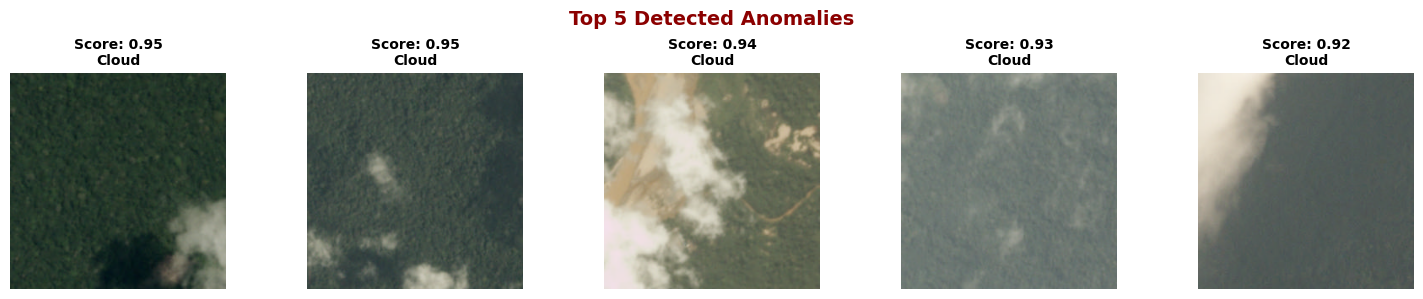

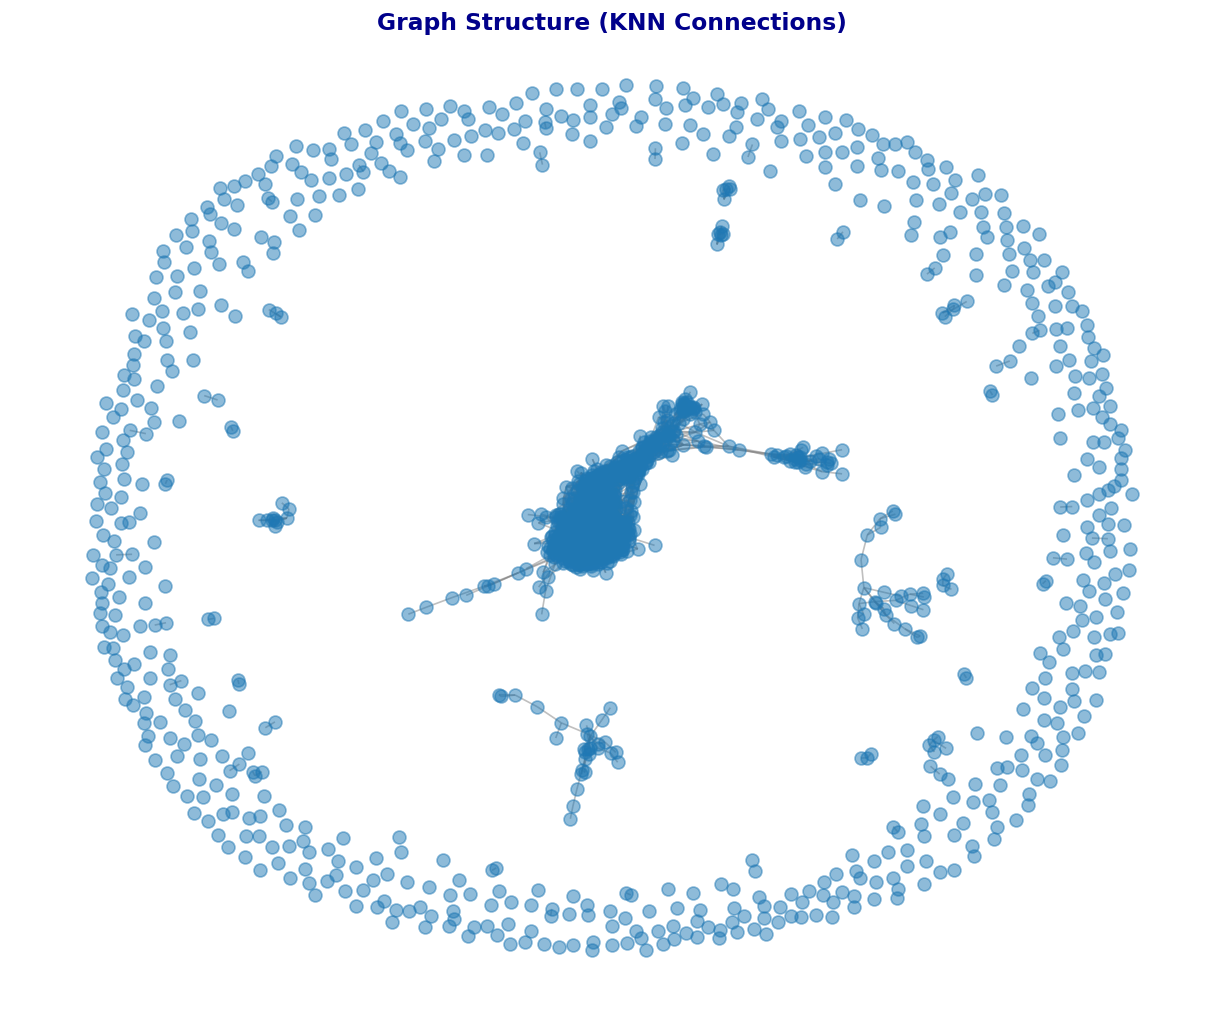

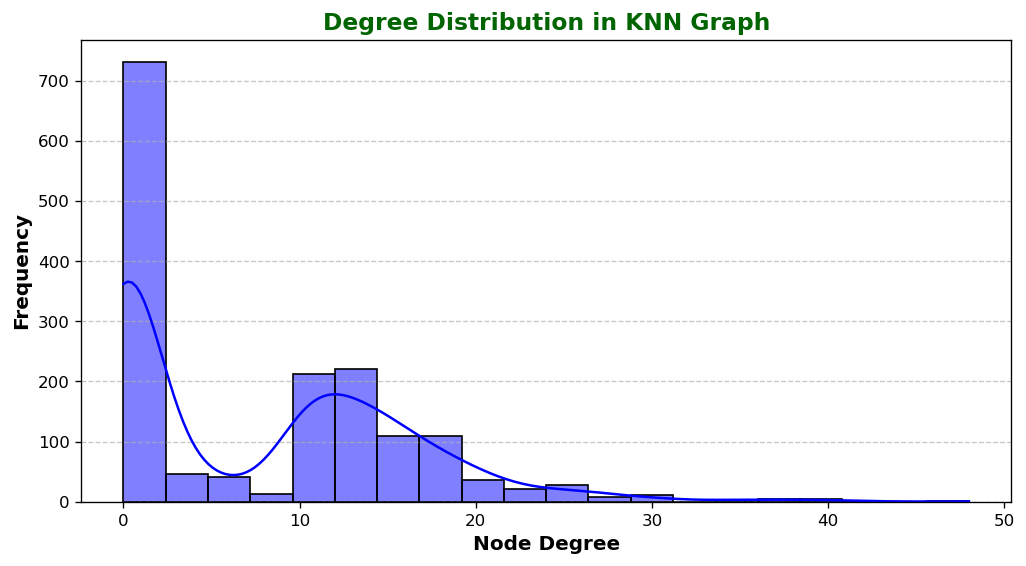

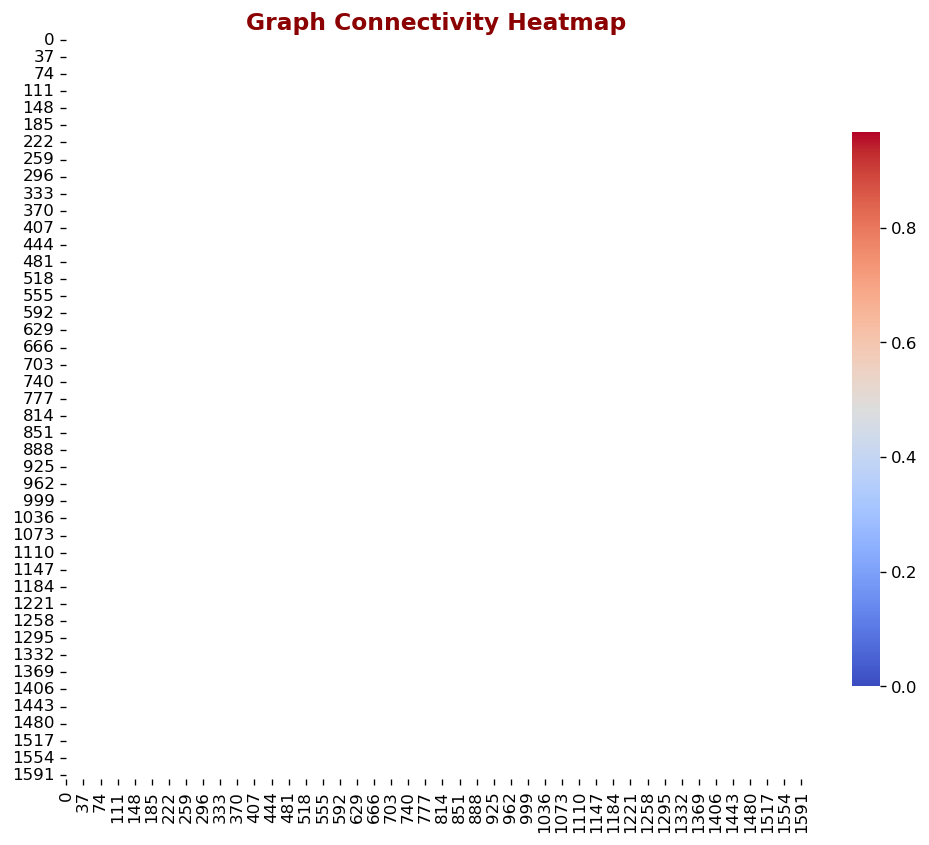

In [19]:
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Feature Extractor Class
class FeatureExtractor:
    def __init__(self):
        self.model = None
        self.preprocess = None
        
    def extract(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_t = self.preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        with torch.no_grad():
            features = self.model(batch_t)
        return features.squeeze().cpu().numpy()

class ResNet50Extractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1]).to(device)  # Remove FC layer
        self.model.eval()
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Step 1: Feature Extraction
def load_and_extract_features(data_dir, extractor):
    features, labels, img_paths = [], [], []
    
    for label, class_dir in enumerate(['noncloud', 'cloud']):
        dir_path = os.path.join(data_dir, class_dir)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        
        img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not img_files:
            raise ValueError(f"No images found in {dir_path}")
        
        for img_name in tqdm(img_files, desc=f"Extracting {class_dir} features"):
            img_path = os.path.join(dir_path, img_name)
            try:
                feat = extractor.extract(img_path)
                features.append(feat.flatten())
                labels.append(label)
                img_paths.append(img_path)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    
    return np.array(features), np.array(labels), img_paths

# Step 2: Graph Construction
def build_knn_graph(features, k=10, similarity_threshold=0.6):
    features_norm = StandardScaler().fit_transform(features)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(features_norm)
    distances, indices = nbrs.kneighbors(features_norm)
    
    G = nx.Graph()
    for i in range(len(features_norm)):
        G.add_node(i)
    
    for i in range(len(features_norm)):
        for j_idx, j in enumerate(indices[i][1:]):
            sim = 1 - distances[i][j_idx+1]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)
    
    return G

# Step 3: Anomaly Scoring
def compute_graph_anomaly_scores(G):
    scores = {}
    
    # PageRank
    pr = nx.pagerank(G)
    pr_scores = np.array(list(pr.values()))
    scores['pagerank'] = {node: 1 - (score / max(pr_scores)) for node, score in pr.items()}
    
    # Eccentricity
    try:
        ecc = nx.eccentricity(G)
    except:
        ecc = {node: max(nx.single_source_shortest_path_length(G, node).values()) for node in G.nodes()}
    scores['eccentricity'] = {node: score/max(ecc.values()) for node, score in ecc.items()}
    
    # Combined score
    combined_scores = {node: 0.5 * scores['pagerank'][node] + 0.5 * scores['eccentricity'][node] for node in G.nodes()}
    
    return combined_scores

# Step 4: Evaluation
def evaluate_anomaly_detection(labels, anomaly_scores):
    y_true = labels
    y_scores = np.array([anomaly_scores[i] for i in range(len(labels))])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    return classification_report(y_true, y_pred, target_names=['Non-Cloud', 'Cloud']), ap

# Step 5: Visualization
def visualize_results(img_paths, anomaly_scores, labels, features, top_n=5):
    top_indices = np.argsort(-np.array(list(anomaly_scores.values())))[:top_n]
    
    # Displaying Top N Anomalous Images
    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_n, i+1)
        img = Image.open(img_paths[idx])
        plt.imshow(img)
        plt.title(f"Score: {anomaly_scores[idx]:.2f}\n{'Cloud' if labels[idx] else 'Non-Cloud'}", fontsize=10, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(f'Top {top_n} Detected Anomalies', fontsize=14, fontweight='bold', color='darkred')
    plt.tight_layout()
    plt.show()

    # Graph Structure
    plt.figure(figsize=(10, 8), dpi=120)
    G = build_knn_graph(features)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=60, edge_color="gray", alpha=0.5, with_labels=False)
    
    plt.title("Graph Structure (KNN Connections)", fontsize=14, fontweight='bold', color='darkblue')
    plt.show()

    # Degree Distribution
    plt.figure(figsize=(10, 5), dpi=120)
    degrees = [val for (node, val) in G.degree()]
    sns.histplot(degrees, bins=20, kde=True, color="blue", edgecolor="black")
    
    plt.xlabel("Node Degree", fontsize=12, fontweight='bold')
    plt.ylabel("Frequency", fontsize=12, fontweight='bold')
    plt.title("Degree Distribution in KNN Graph", fontsize=14, fontweight='bold', color='darkgreen')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    # Heatmap of KNN Similarity
    plt.figure(figsize=(10, 8), dpi=120)
    adjacency_matrix = nx.to_numpy_array(build_knn_graph(features), weight='weight')
    
    sns.heatmap(adjacency_matrix, cmap="coolwarm", square=True, linewidths=0.5, annot=False, cbar_kws={'shrink': 0.75})
    plt.title("Graph Connectivity Heatmap", fontsize=14, fontweight='bold', color='darkred')
    plt.show()

# Main Execution
if __name__ == "__main__":
    data_dir = r"E:\\Ml project\\archive"
    extractor = ResNet50Extractor()
    
    features, labels, img_paths = load_and_extract_features(data_dir, extractor)
    G = build_knn_graph(features)
    anomaly_scores = compute_graph_anomaly_scores(G)
    report, ap = evaluate_anomaly_detection(labels, anomaly_scores)
    
    print("\nClassification Report:")
    print(report)
    print(f"Average Precision Score: {ap:.2f}")
    
    visualize_results(img_paths, anomaly_scores, labels, features)


Extracting cloud features: 100%|██████████████████████████████████████████████████████████████████| 100/100 [00:19<00:00,  5.02it/s]



Classification Report:
              precision    recall  f1-score   support

   Non-Cloud       0.95      0.97      0.96      1500
       Cloud       0.34      0.21      0.26       100

    accuracy                           0.93      1600
   macro avg       0.65      0.59      0.61      1600
weighted avg       0.91      0.93      0.92      1600

Average Precision Score: 0.21


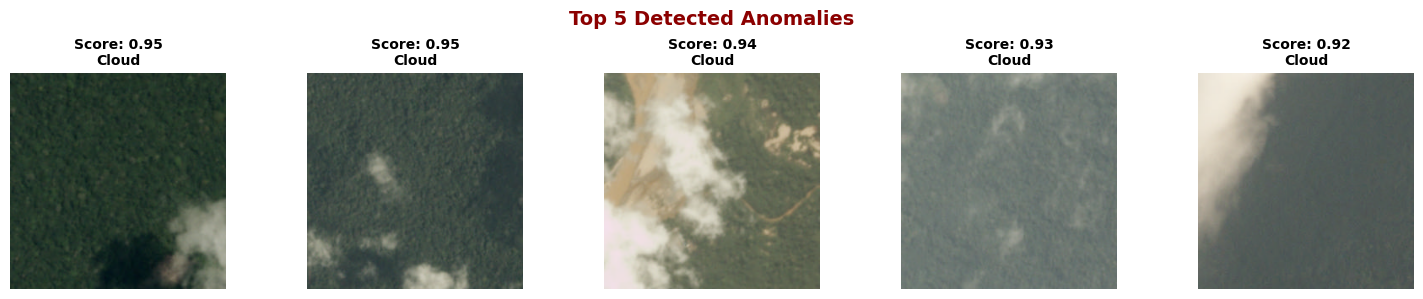

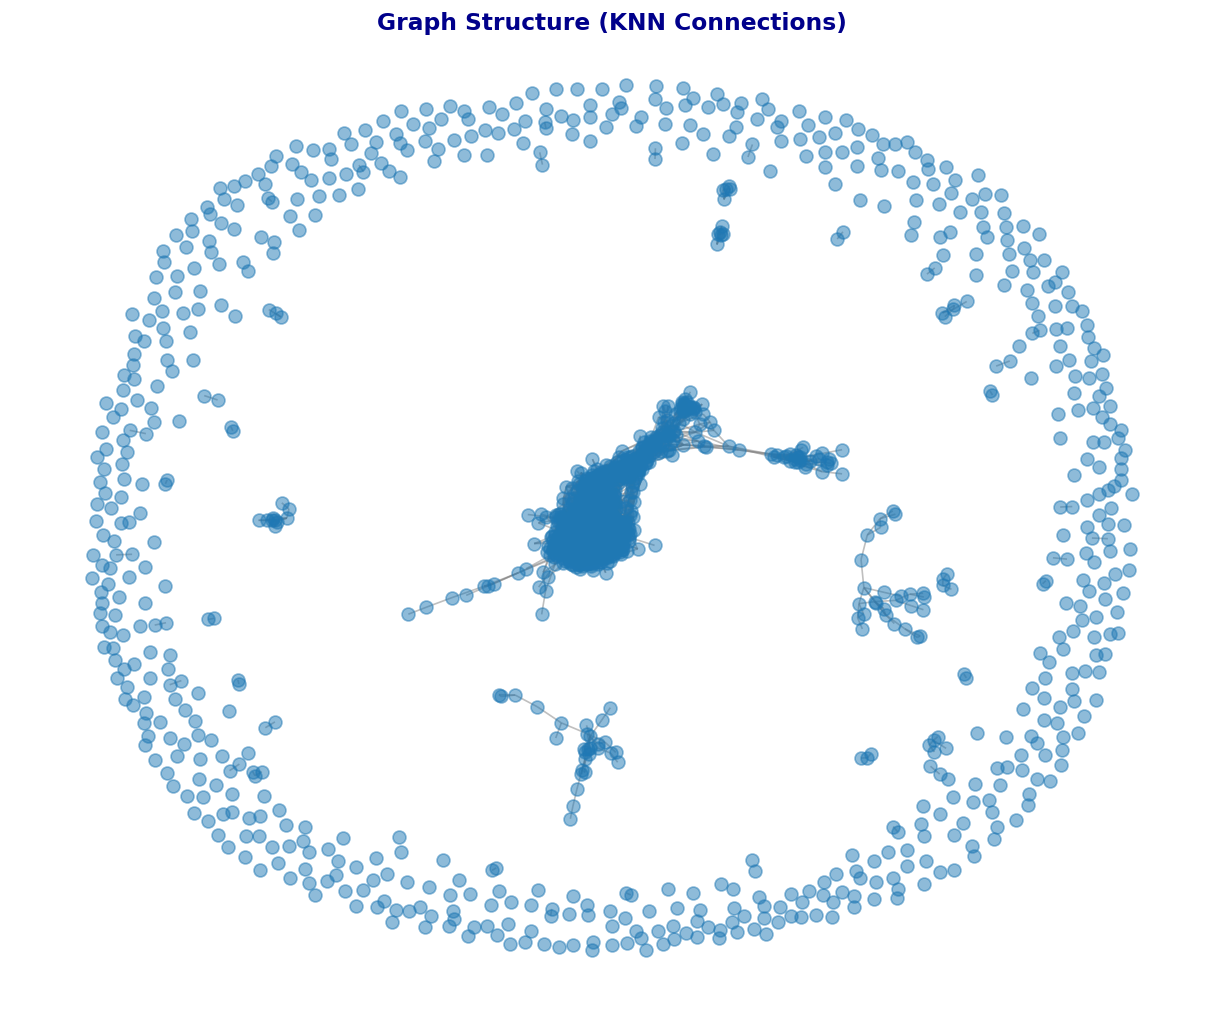

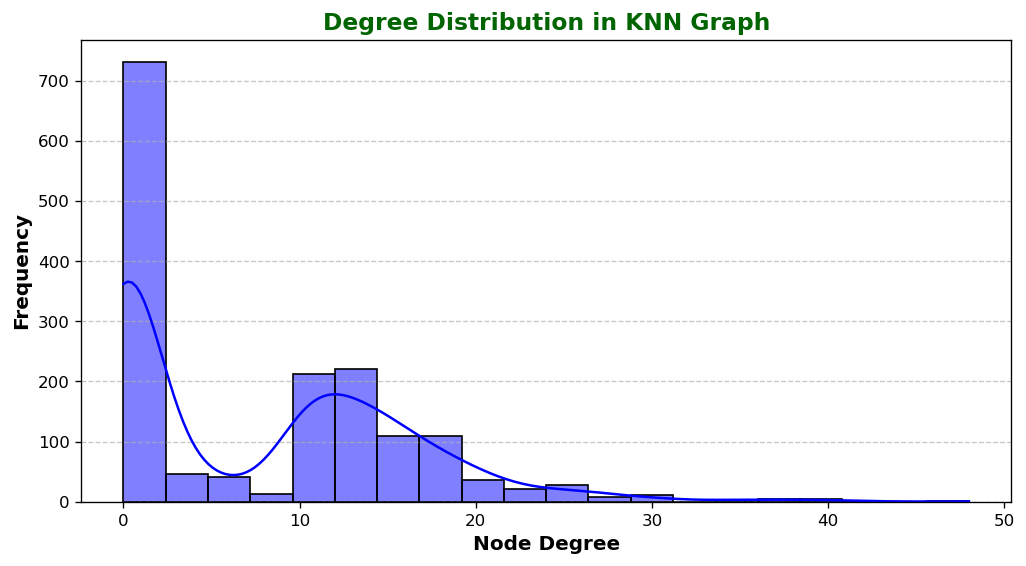

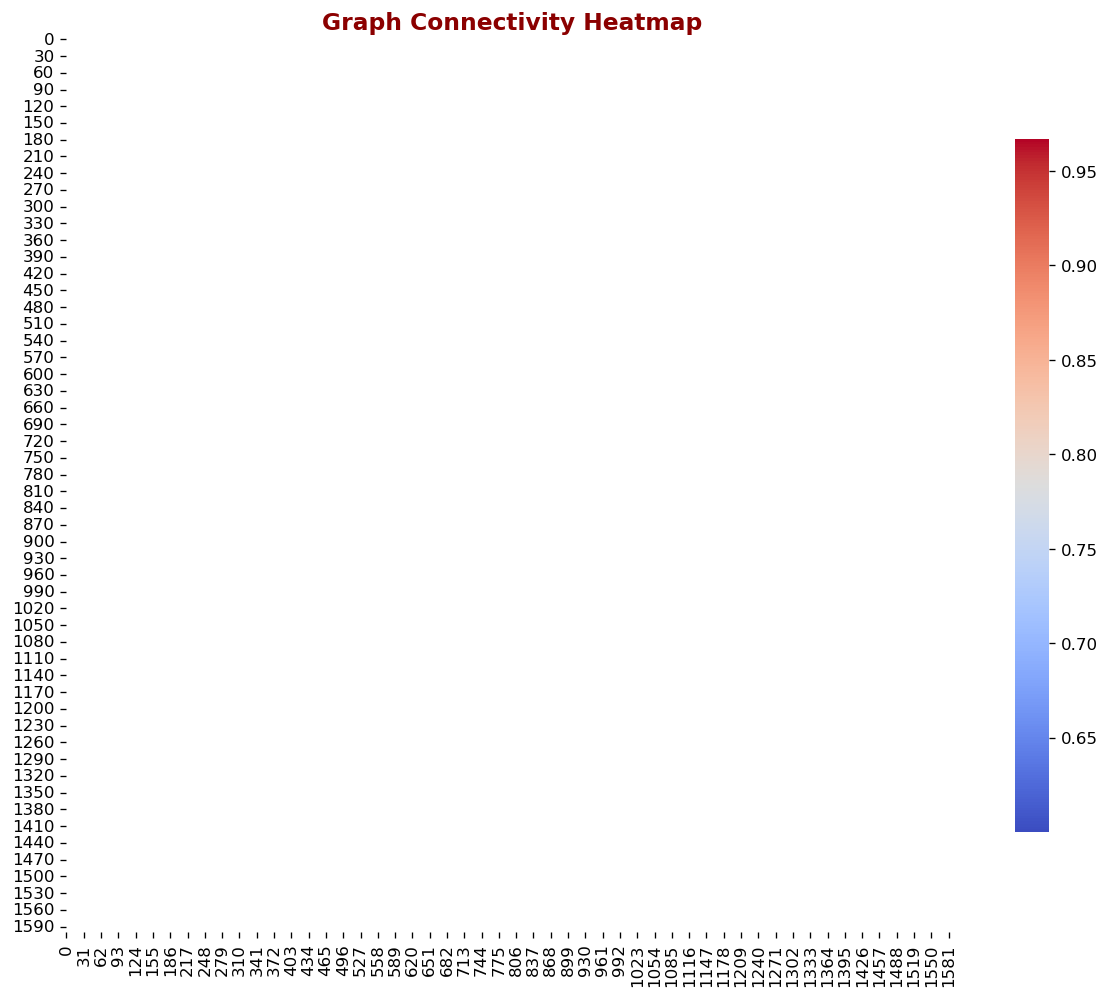

In [27]:
import os
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

np.random.seed(42)
torch.manual_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FeatureExtractor:
    def __init__(self):
        self.model = None
        self.preprocess = None
        
    def extract(self, img_path):
        img = Image.open(img_path).convert('RGB')
        img_t = self.preprocess(img)
        batch_t = torch.unsqueeze(img_t, 0).to(device)
        with torch.no_grad():
            features = self.model(batch_t)
        return features.squeeze().cpu().numpy()

class ResNet50Extractor(FeatureExtractor):
    def __init__(self):
        super().__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1]).to(device) 
        self.model.eval()
        self.preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

def load_and_extract_features(data_dir, extractor):
    features, labels, img_paths = [], [], []
    
    for label, class_dir in enumerate(['noncloud', 'cloud']):
        dir_path = os.path.join(data_dir, class_dir)
        if not os.path.exists(dir_path):
            raise FileNotFoundError(f"Directory not found: {dir_path}")
        
        img_files = [f for f in os.listdir(dir_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not img_files:
            raise ValueError(f"No images found in {dir_path}")
        
        for img_name in tqdm(img_files, desc=f"Extracting {class_dir} features"):
            img_path = os.path.join(dir_path, img_name)
            try:
                feat = extractor.extract(img_path)
                features.append(feat.flatten())
                labels.append(label)
                img_paths.append(img_path)
            except Exception as e:
                print(f"Skipping {img_path}: {e}")
    
    return np.array(features), np.array(labels), img_paths

def build_knn_graph(features, k=10, similarity_threshold=0.6):
    features_norm = StandardScaler().fit_transform(features)
    nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(features_norm)
    distances, indices = nbrs.kneighbors(features_norm)
    
    G = nx.Graph()
    for i in range(len(features_norm)):
        G.add_node(i)
    
    for i in range(len(features_norm)):
        for j_idx, j in enumerate(indices[i][1:]):
            sim = 1 - distances[i][j_idx+1]
            if sim > similarity_threshold:
                G.add_edge(i, j, weight=sim)
    
    return G

def compute_graph_anomaly_scores(G):
    scores = {}
    
    pr = nx.pagerank(G)
    pr_scores = np.array(list(pr.values()))
    scores['pagerank'] = {node: 1 - (score / max(pr_scores)) for node, score in pr.items()}
    
    try:
        ecc = nx.eccentricity(G)
    except:
        ecc = {node: max(nx.single_source_shortest_path_length(G, node).values()) for node in G.nodes()}
    scores['eccentricity'] = {node: score/max(ecc.values()) for node, score in ecc.items()}
    
    combined_scores = {node: 0.5 * scores['pagerank'][node] + 0.5 * scores['eccentricity'][node] for node in G.nodes()}
    
    return combined_scores

def evaluate_anomaly_detection(labels, anomaly_scores):
    y_true = labels
    y_scores = np.array([anomaly_scores[i] for i in range(len(labels))])
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    ap = average_precision_score(y_true, y_scores)
    
    optimal_idx = np.argmax(2 * (precision * recall) / (precision + recall + 1e-10))
    optimal_threshold = thresholds[optimal_idx]
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    return classification_report(y_true, y_pred, target_names=['Non-Cloud', 'Cloud']), ap

def visualize_results(img_paths, anomaly_scores, labels, features, top_n=5):
    top_indices = np.argsort(-np.array(list(anomaly_scores.values())))[:top_n]
    

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(top_indices):
        plt.subplot(1, top_n, i+1)
        img = Image.open(img_paths[idx])
        plt.imshow(img)
        plt.title(f"Score: {anomaly_scores[idx]:.2f}\n{'Cloud' if labels[idx] else 'Non-Cloud'}", fontsize=10, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(f'Top {top_n} Detected Anomalies', fontsize=14, fontweight='bold', color='darkred')
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 8), dpi=120)
    G = build_knn_graph(features)
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, node_size=60, edge_color="gray", alpha=0.5, with_labels=False)
    
    plt.title("Graph Structure (KNN Connections)", fontsize=14, fontweight='bold', color='darkblue')
    plt.show()


    plt.figure(figsize=(10, 5), dpi=120)
    degrees = [val for (node, val) in G.degree()]
    sns.histplot(degrees, bins=20, kde=True, color="blue", edgecolor="black")
    
    plt.xlabel("Node Degree", fontsize=12, fontweight='bold')
    plt.ylabel("Frequency", fontsize=12, fontweight='bold')
    plt.title("Degree Distribution in KNN Graph", fontsize=14, fontweight='bold', color='darkgreen')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    adjacency_matrix = nx.to_numpy_array(build_knn_graph(features), weight='weight')

    plt.figure(figsize=(12, 10), dpi=120)
    mask = adjacency_matrix == 0 
    sns.heatmap(
        adjacency_matrix + 1e-9,  
        cmap="coolwarm",
        square=True,
        linewidths=0.5,
        annot=False,
        mask=mask,  
        cbar_kws={'shrink': 0.75}
    )
    plt.title("Graph Connectivity Heatmap", fontsize=14, fontweight='bold', color='darkred')
    plt.show()

if __name__ == "__main__":
    data_dir = r"E:\\Ml project\\archive"
    extractor = ResNet50Extractor()
    
    features, labels, img_paths = load_and_extract_features(data_dir, extractor)
    G = build_knn_graph(features)
    anomaly_scores = compute_graph_anomaly_scores(G)
    report, ap = evaluate_anomaly_detection(labels, anomaly_scores)
    
    print("\nClassification Report:")
    print(report)
    print(f"Average Precision Score: {ap:.2f}")

    visualize_results(img_paths, anomaly_scores, labels, features)
